In [30]:
"""
Created on Fri Nov  5 13:12:38 2021

@author: seongjoon kang
"""
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

class MyHMM():
    def __init__(self, n_state = 3, init_prob =np.array([1/6,1/6, 2/3]), 
                 A_trans = np.array([[0.3,0.4, 0.3],[0.4,0.2,0.4],[0.3, 0.4, 0.3]]), data = None):
        self.n_state = n_state # number state
        self.init_prob = init_prob # intial probability
        self.A_trans = A_trans # transition matrix
        self.mu_em = np.zeros(n_state) # mean value of emission probability distribution
        self.sigma_em = np.ones(n_state) # variance of emission probability distribution
        if len(data) == 0:
            data =  pd.read_csv('sp500w.csv')
        self.observation = np.array(data)[:,1] # oberved data
        self.n_time = len(self.observation) # total time steps
        
    def get_prob(self, x,mu,sigma):
        """
        The function to compute the probability with cdf
        when variances are very small, pdf values are more than 1 
        So, we use the difference of cdf values between x and x+dx
        """
        dx = 1e-4
        cdf1 = stats.norm.cdf(x+dx, loc = mu, scale = np.sqrt(sigma))
        cdf2 = stats.norm.cdf(x-dx, loc = mu, scale = np.sqrt(sigma))
        #print (cdf1-cdf2)
        return cdf1 - cdf2
    
    def forward_procedure(self):
        # compute alpha values by forwarding messages
        # also, we obtain the scalar variable, c_i, to normalize beta and sigma later
        
        alpha = np.zeros((self.n_state, self.n_time)) # alpha_i
        alpha_hat = np.zeros((self.n_state, self.n_time)) # alpha_i
        c_i = np.zeros(self.n_time)
        #observation = self.observation
        for time_i in range(self.n_time): # go forward through all observation from t =1 
          for state_j in range(self.n_state): # for each observation,
            #em_prob_state_j_time_i = self.get_prob(self.observation[time_i], self.mu_em[state_j], self.sigma_em[state_j])
            em_prob_state_j_time_i = stats.norm.pdf(self.observation[time_i], loc = self.mu_em[state_j]
                                                  , scale = np.sqrt(self.sigma_em[state_j]))
               
            if (time_i==0): # set initial value of alpha_0
              # alpha_0_state_j = phi_state_j *prob(x_i|state_j)
              alpha[state_j, time_i] = self.init_prob[state_j] * em_prob_state_j_time_i
            else:
              # alpha[z_i] = emission_prob * sum(alpha[z_i-1 * p_zi_zi-1])
              alpha[state_j, time_i] = (em_prob_state_j_time_i* alpha[:,time_i-1] * self.A_trans[:,state_j]).sum()
              # obtain c_i,
              #if (time_i ==0):
          c_i[time_i] = alpha[:,time_i].sum()
          #else:
        #c_i[time_i] = 1/(alpha[:,time_i-1].sum())
          # normalize alpha
          alpha[:, time_i] /=c_i[time_i]
        return alpha, c_i
    
    def backward_procedure(self, c_i):
      # calculate the beta values by backward procedures
    
      beta = np.zeros((self.n_state, self.n_time)) # beta_i
      
      for time_i in range(1,self.n_time+1):
        for state_j in range(self.n_state):
          # set initial state
          if time_i ==1: # if time_i indicates the last time step
            beta[state_j, -time_i] = 1.0
          else: # go backward from the end-time-step
            for k in range(self.n_state): # k = z_i+1
              # P (x_i+1 | z_i+1)
              #em_prob_state_time = self.get_prob(self.observation[-time_i+1], self.mu_em[k], self.sigma_em[k])
              
              em_prob_state_time = stats.norm.pdf(self.observation[-time_i+1], 
                loc = self.mu_em[k] , scale = np.sqrt(self.sigma_em[k]))
              # beta_z_i = sum(beta(z_i+1) * em_prob * P(z_i+1|z_i))
              beta[state_j, -time_i] += beta[k, -time_i+1] * em_prob_state_time * self.A_trans[state_j, k]
        beta[:, -time_i] /=c_i[-time_i+1]#
      return beta #, start_value.sum()
  
    def sigma_prob(self, alpha, beta, c_i):
      # compute sigma probabilities
    
      sigma_probability = np.zeros((self.n_time-1, self.n_state, self.n_state))
      
      for time_i in range(self.n_time-1):
        for j in range(self.n_state): # states of z_i
          for k in range(self.n_state): # states of z_i+1
            # sigma(z_i_j, z_i+1_k) = alpha(z_i) * P(z_i+1|z_i) * P(x_i+1|z_i+1)*beta(z_i+1)/c_i+1
            # emission probability = P(x_i+1|z_i+1) 
            #em_prob = self.get_prob(self.observation[time_i+1], self.mu_em[k], self.sigma_em[k])
            em_prob = stats.norm.pdf(self.observation[time_i+1], loc = self.mu_em[k], 
            scale = np.sqrt(self.sigma_em[k]))
            sigma_probability[time_i,j,k] = alpha[j,time_i] * beta[k, time_i+1] * self.A_trans[j,k] * em_prob / c_i[time_i+1]
      return sigma_probability

    def gamma_prob(self,alpha, beta):
     # compute gamma probabilities
    
      gamma_probability = np.zeros((self.n_state, self.n_time))
      
      for time_i in range(self.n_time):
        for state_j in range(self.n_state):
          gamma_probability[state_j, time_i] = alpha[state_j, time_i] * beta[state_j, time_i]#/beta_normalized
   
      return gamma_probability
  
    def viterbi_algorithm(self, x):
        # viterbi algorithm we implemented in lab 6
        """
        Auxiliary method that uses Viterbi on single chain
        @param X: array-like with dimension [ # of length]
        @return z: array-like with dimension [# of length]
        """
        # init holders
        z = []
        y = z
        V = np.zeros( (len(x), self.n_state) )
        best_states = np.zeros( (len(x), self.n_state) )
        # forward
        for time_i in np.arange(self.n_time):
            for state_j in np.arange(self.n_state):
                # compute v_t_j
                if time_i== 0:
                    p_v = np.log(self.init_prob)# initial state
                else:
                    p_v = V[time_i-1, :] # take the previous value
                #em_prob = self.get_prob(x[time_i], self.mu_em[state_j],  self.sigma_em[state_j])
                em_prob = stats.norm.pdf(x[time_i], loc = self.mu_em[state_j], scale = np.sqrt(self.sigma_em[state_j]))
                next_list = p_v + np.log(self.A_trans[:,state_j]) + np.log(em_prob)
                next_candidate_i = np.argmax(next_list)
                V[time_i,state_j] = next_list[next_candidate_i]
                best_states[time_i,state_j] = int(next_candidate_i)
        # backward step, collect all the latent states
        for t in np.arange(len(x), 0, step = -1):
            if t == len(x):
                c_j = int(np.argmax(V[t-1, :]))
                z.append(c_j)
            else:
                c_j = int(best_states[t, c_j])
                z.append(c_j)
        
        return np.flip(z)
    
    def train(self, n_iter = 50, period_of_printing = 10):
        # train my-hmm when it converges, 
        # I just set number of iteration that is sufficient for convergence of my model
        for it in range(n_iter):
            # E-Step
            fwd_probs, c_i = self.forward_procedure()
            bwd_probs = self.backward_procedure(c_i)
        
            sigma_probabilities = self.sigma_prob(fwd_probs, bwd_probs, c_i)
            gamma_probabilities = self.gamma_prob(fwd_probs, bwd_probs)

            # M-Step
            #caclculating transition matrix 
            # and mean and variance of gaussian distribution
            A_trans = np.zeros((n_state, n_state))
            for j in range(self.n_state):
                for i in range(self.n_state):
                    for t in range(self.n_time-1):
                        A_trans[j,i] = A_trans[j,i] + sigma_probabilities[t,j,i] 
                    denomenator_A = [sigma_probabilities[t_x,j, i_x] for t_x in range(self.n_time - 1) for i_x in range(self.n_state)]
                    # we update transition matrix, A, in the below way
                    denomenator_A = np.sum(denomenator_A)
                    if (denomenator_A == 0):
                        A_trans[j,i] = 0
                    else:
                        A_trans[j,i] = A_trans[j,i]/denomenator_A
            self.A_trans = A_trans
            prev_init = self.init_prob.copy()
            #for state_j in range(n_state):
            self.init_prob = gamma_probabilities[:,0]/gamma_probabilities[:,0].sum()
            # We update mean and variance values for each state of every time step
            mu_em_new = np.zeros_like(self.mu_em)
            sigma_em_new  = np.zeros_like(self.sigma_em)
            for state_j in range(n_state):
              # according to the formular given at lecture note 6 page 23
              denom = gamma_probabilities[state_j,:].sum()
              mu_em_new[state_j] = (gamma_probabilities[state_j,:]*self.observation).sum() / denom
              sigma_em_new[state_j] = ((gamma_probabilities[state_j,:]*self.observation*self.observation).sum())/denom - self.mu_em[state_j]**2
        
            self.mu_em = mu_em_new.copy()
            self.sigma_em = sigma_em_new.copy()
            if it % period_of_printing ==0:
                print ('number of iteration: ',it)
                print('Matrix A_tran:')
                print(np.matrix(A_trans.round(decimals=4)))
                print('Mu')
                print(self.mu_em)
                print ('Sigma')
                print (np.sqrt(self.sigma_em))
                print ('init prob', self.init_prob)
                print ('----------------------------\n')
                diff =  np.abs(prev_init - init_prob)
            #print('Difference in forward probability: ', diff)
            #if (np.linalg.norm(diff) < 0.000001) and it !=0:
            #    break
    def plot_labels(self):
        # plot labels of latent variables we found by viterbi
        z = self.viterbi_algorithm(self.observation)
        plt.figure(figsize= (10,6))
        plt.plot(np.arange(self.n_time), self.observation, 'k-.', linewidth = 0.5)
        colors = {1:'k', 2:'r', 3:'b'}
        for i in range(self.n_time):
            plt.text(i, self.observation[i], z[i]+1, c = colors[z[i]+1])
        self.z = z
        
    def compute_log_likelihood(self):
        # compute the loglikelihood and c_i which is the scaled version
        init_p = self.init_prob[self.z[0]]
        next_p = init_p
        z_prev = self.z[0]
        # log-liklikhood is computed by following the most probable path
        for i, zz in enumerate(self.z): 
            em_prob = self.get_prob(self.observation[i], self.mu_em[zz], self.sigma_em[zz])
            next_p += np.log10(self.A_trans[z_prev, zz]) + np.log10(em_prob)
            z_prev = zz

        alpha, c_i = self.forward_procedure()
        print ('scaled marginalized probability (alpha/c_i): ', alpha[:,-1].sum()/c_i[-1])
        print ('marginal log-likelihood (log10(P(X))) : ', next_p)

#  K = 3  CASE

In [26]:
data =  pd.read_csv('sp500w.csv')
n_state= 3
A_trans = np.array([[0.3,0.4, 0.3],[0.4,0.2,0.4],[0.3, 0.4, 0.3]])
init_prob =  np.array([1/6,1/6, 2/3])

myHMM = MyHMM(n_state = n_state, init_prob=init_prob, A_trans = A_trans,
              data = data)
myHMM.train(n_iter = 551, period_of_printing = 50)

number of iteration:  0
Matrix A_tran:
[[0.3 0.4 0.3]
 [0.4 0.2 0.4]
 [0.3 0.4 0.3]]
Mu
[0.00094079 0.00094778 0.00104748]
Sigma
[0.02607176 0.02607056 0.02611151]
init prob [0.16666667 0.16666667 0.66666667]
----------------------------

number of iteration:  50
Matrix A_tran:
[[5.373e-01 4.626e-01 1.000e-04]
 [7.392e-01 2.217e-01 3.900e-02]
 [4.150e-02 1.250e-02 9.461e-01]]
Mu
[ 0.00772098 -0.00652254 -0.00339981]
Sigma
[0.01286536 0.0171197  0.04437287]
init prob [5.22232224e-49 3.89130547e-48 1.00000000e+00]
----------------------------

number of iteration:  100
Matrix A_tran:
[[5.912e-01 4.088e-01 0.000e+00]
 [7.843e-01 1.704e-01 4.530e-02]
 [5.450e-02 3.000e-04 9.452e-01]]
Mu
[ 0.00771454 -0.00849208 -0.00340214]
Sigma
[0.01288496 0.0165918  0.04441449]
init prob [1.16812011e-106 1.95322916e-125 1.00000000e+000]
----------------------------

number of iteration:  150
Matrix A_tran:
[[0.6558 0.3442 0.    ]
 [0.8025 0.1454 0.0521]
 [0.0543 0.     0.9457]]
Mu
[ 0.00725835 -0.009825

<ipython-input-25-249b93b9fbcb>:131: RuntimeWarning: divide by zero encountered in log
  p_v = np.log(self.init_prob)# initial state


scaled marginalized probability (alpha/c_i):  0.08161815092407841
marginal log-likelihood (log10(P(X))) :  -1351.603955324236


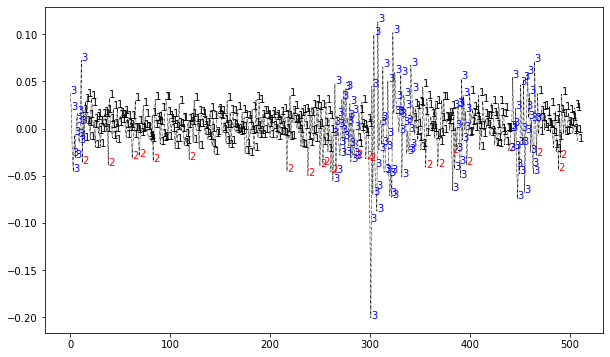

In [27]:
myHMM.plot_labels()
myHMM.compute_log_likelihood()

# K = 2 CASE

In [33]:
n_state= 2
A_trans = np.array([[0.3,0.7],[0.7,0.3]])
init_prob =  np.array([1/3, 2/3])
myHMM2 = MyHMM(n_state = n_state, init_prob=init_prob, A_trans = A_trans,
              data = data)
myHMM2.train(n_iter = 351, period_of_printing = 50)

number of iteration:  0
Matrix A_tran:
[[0.3 0.7]
 [0.7 0.3]]
Mu
[0.00096119 0.00099629]
Sigma
[0.0260757  0.02609357]
init prob [0.33333333 0.66666667]
----------------------------

number of iteration:  50
Matrix A_tran:
[[0.9846 0.0154]
 [0.0533 0.9467]]
Mu
[ 0.00262773 -0.00392139]
Sigma
[0.01596468 0.04369262]
init prob [6.85496885e-47 1.00000000e+00]
----------------------------

number of iteration:  100
Matrix A_tran:
[[0.9846 0.0154]
 [0.0533 0.9467]]
Mu
[ 0.00262748 -0.00392177]
Sigma
[0.01596532 0.04369522]
init prob [7.21438783e-113 1.00000000e+000]
----------------------------

number of iteration:  150
Matrix A_tran:
[[0.9846 0.0154]
 [0.0533 0.9467]]
Mu
[ 0.00262748 -0.00392177]
Sigma
[0.01596532 0.04369522]
init prob [7.60716542e-179 1.00000000e+000]
----------------------------

number of iteration:  200
Matrix A_tran:
[[0.9846 0.0154]
 [0.0533 0.9467]]
Mu
[ 0.00262748 -0.00392177]
Sigma
[0.01596532 0.04369522]
init prob [8.02132726e-245 1.00000000e+000]
--------------

<ipython-input-30-249b93b9fbcb>:131: RuntimeWarning: divide by zero encountered in log
  p_v = np.log(self.init_prob)# initial state


scaled marginalized probability (alpha/c_i):  0.06710755657552557
marginal log-likelihood (log10(P(X))) :  -1353.5620878394893


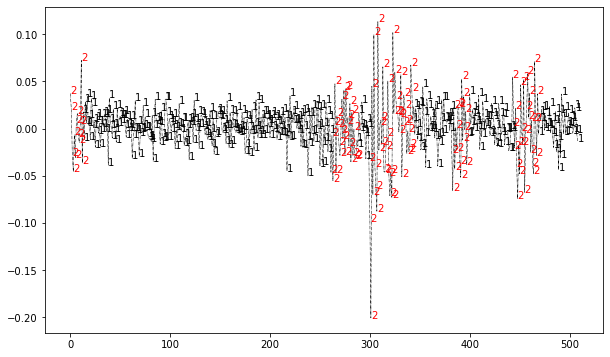

In [34]:
myHMM2.plot_labels()
myHMM2.compute_log_likelihood()

# Comparison

We can conclude that when K = 3,  the marginal probability is larger than K=2 from comparison of scaled $c_t$ and marginal log-likelihood values.<br>
Hence, **the model employing three latent variables (K=3) is better**